In [2]:
import gymnasium as gym
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import copy
import pickle

/home/zoid/miniconda3/envs/ai/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-02-27 14:32:10.657756: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 14:32:11.300405: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/zoid/miniconda3/envs/ai/lib/python3.9/site-packages/cv2/../../lib64::/home/zoid/miniconda3/envs/ai/lib/
2023-02-27 14:32:11.300467: 

In [2]:
env = gym.make("CartPole-v1", render_mode='rgb_array')

In [3]:
def make_game_video(env, model=None , MAX_DUR=1000):
    img_array = []
    size = None
    state = env.reset()[0]
    img_array.append(env.render())
    for i in range(MAX_DUR):
        if model == None:
            action = env.action_space.sample()
        else :
            action_prob = model(np.array([state]))
            action = np.argmax(action_prob)
        state = env.step(action)[0]
        img = env.render()
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img_array.append(img)
    
    size = img_array[0].shape
    size = size[:2]
    vid = cv2.VideoWriter('game_vid.avi' , cv2.VideoWriter_fourcc(*'DIVX'), fps=15 ,frameSize=size)
    for i in img_array:
        vid.write(i)
    vid.release()

In [4]:
def make_model():
    inps = keras.layers.Input(shape=(4))
    x = keras.layers.Dense(200, activation='relu')(inps)
    outs = keras.layers.Dense(2, activation='softmax')(x)
    model = keras.Model(inputs=inps , outputs=outs)
    return model

def running_mean(a , l=20):
    x = []
    for i in range(len(a)-l):
        x.append(sum(a[i:i+l])/l)
    return x

In [17]:
# TRAINING WITH EXPERIENCE REPLAY:

model = make_model()

env = gym.make("CartPole-v1", render_mode='rgb_array')

optimizer = keras.optimizers.RMSprop(learning_rate=0.001)


epochs = 1000
episode_len = 300

gamma = 0.99
loss_history = []

for epoch in range(epochs):
    state1 = env.reset()[0]
    done = False
    t = 0
    replay = []
        
    for t in range(episode_len):
        action_prob = model(np.array([state1]))[0]
        action = np.random.choice([0,1], p=np.array(action_prob))
        state2 , r, done , truncated , info = env.step(action)
        experience = [state1, action , t+1]
        replay.append(experience)
        state1 = state2
        if done :
            break
    
    t+=1
    action_batch = [a for (s,a,r) in replay]
    state_batch = [s for (s,a,r) in replay]
    reward_batch = [r for (s,a,r) in replay]
    
    reward_batch = np.array(reward_batch[::-1])
    g = np.power(gamma, np.arange(t))*reward_batch
    g = g/np.max(g)
    
    with tf.GradientTape() as tape:
        pred_batch = model(np.array(state_batch),  training=True)
        prob_batch = tf.gather_nd(pred_batch , indices=[[i,j] for i,j in enumerate(action_batch)])
        loss = -tf.reduce_sum(g * tf.math.log(prob_batch))
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    loss_history.append(t)


KeyboardInterrupt: 

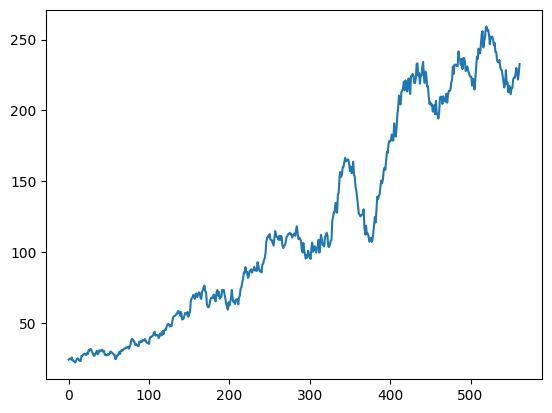

In [18]:
losses = running_mean(loss_history)
plt.plot(losses)

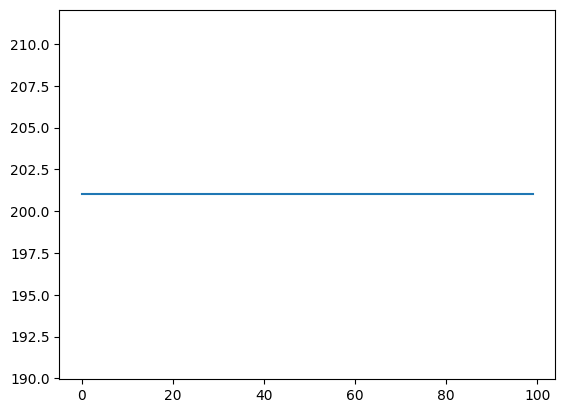

In [20]:
def play(game, agent):
    s = game.reset()[0]
    done = False
    t = 0
    ep_len = 200
    while not done:
        a = np.argmax(agent(np.array([s]))[0])
        s , r, done , __ ,___ = game.step(a)
        t+=1
        if (t>ep_len):
            break
    return t

max_games = 100
games_hist = []
for i in range(max_games):
    games_hist.append(play(env, model))

plt.plot(games_hist)

In [23]:
with open("model.keras", 'wb') as f:
    pickle.dump(model, f)
    f.close()

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......input_layer
.........vars
...vars
Keras model archive saving:
File Name                                             Modified             Size
variables.h5                                   2023-02-27 14:24:09        17552
metadata.json                                  2023-02-27 14:24:09           64
config.json                                    2023-02-27 14:24:09         1412


In [24]:
f = open("model.keras", 'rb')
m = pickle.load(f)
f.close()
m.summary()

Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-02-27 14:24:08        17552
metadata.json                                  2023-02-27 14:24:08           64
config.json                                    2023-02-27 14:24:08         1412
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......input_layer
.........vars
...vars
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_2 (Dense)             (None, 200)               1000      
                                                                 
 dense_3 (De

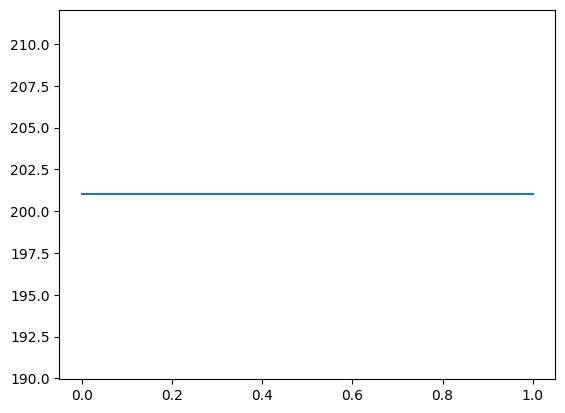

In [27]:
max_games = 2
games_hist = []
for i in range(max_games):
    games_hist.append(play(env, m))

plt.plot(games_hist)